# Tutorial: filling in missing bands

We will use the parameter file "tests/parametersTest.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugriz SDSS bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
%cd ..

/Users/bl/Dropbox/repos/Delight


In [3]:
# First, we must fit the band filters with a gaussian mixture. 
# This is done with this script:
%run ./scripts/processFilters.py tests/parametersTest.cfg

U_SDSS
G_SDSS
R_SDSS
I_SDSS
Z_SDSS


In [4]:
# Second, we will process the library of SEDs and project them onto the filters,
# (for the mean fct of the GP) with the following script:
%run ./scripts/processSEDs.py tests/parametersTest.cfg

In [5]:
# Third, we will make some mock data with those filters and SEDs:
%run ./scripts/simulateWithSEDs.py tests/parametersTest.cfg

In [6]:
# Now we load the parameter file and the useful quantities
params = parseParamFile('tests/parametersTest.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
f_mod = readSEDs(params) # Reads the SED library.
numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
print('Number of Training Objects', numObjectsTraining)

Number of Training Objects 1000


In [7]:
# Create the GP (create interpolation grid for kernel + other internal stuff). May take a while.
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

In [8]:
# Load useful quantities for the training set.
# "CV" means quantities for the bands used for cross-validation.
# In this example we will drop a couple of bands in the training data 
# and use them for cross-validation, as shown in the parameter file.
bandIndicesCV, bandNamesCV, bandColumnsCV,\
    bandVarColumnsCV, redshiftColumnCV =\
    readColumnPositions(params, prefix="training_CV_", refFlux=False)
numBandsCV = bandIndicesCV.size

In [9]:
# Loop and parse the training set, fit the GP to the deep bands, 
# and run cross-validation against the cross-validation bands.
# We will store a bunch of things, including the chi2 of the fit.
numZ = redshiftGrid.size
all_z = np.zeros((numObjectsTraining, ))
all_fluxes = np.zeros((numObjectsTraining, numBands))
all_fluxes_var = np.zeros((numObjectsTraining, numBands))
all_fluxesCV = np.zeros((numObjectsTraining, numBands))
all_fluxesCV_var = np.zeros((numObjectsTraining, numBands))
all_chi2s = np.zeros((numObjectsTraining, numBandsCV))
all_bestTypes = np.zeros((numObjectsTraining, ), dtype=int)

loc = - 1
trainingDataIter1 = getDataFromFile(params, 0, numObjectsTraining,
                                    prefix="training_", getXY=True,
                                    CV=True)
for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
        X, Y, Yvar in trainingDataIter1:
    loc += 1

    # Interpolate template library at spectroscopic redshift
    themod = np.zeros((1, f_mod.shape[0], bands.size))
    for it in range(f_mod.shape[0]):
        for ib, band in enumerate(bands):
            themod[0, it, ib] = f_mod[it, band](z)
    # Run color likelihood to find best template and ML luminosity
    chi2_grid, ellMLs = scalefree_flux_likelihood(fluxes, fluxesVar, themod, returnChi2=True)
    bestType = np.argmin(chi2_grid)
    ell = ellMLs[0, bestType]
    # Use them in the GP
    X[:, 2] = ell
    gp.setData(X, Y, Yvar, bestType)
    
    # Make predictions for all bands (noiseless) from the GP
    model_mean, model_covar\
        = gp.predictAndInterpolate(np.array([z]), ell=ell)
    ind = np.array([list(bandIndicesCV).index(b) for b in bandsCV])
    # Compute chi2 for SDSS bands
    all_chi2s[loc, ind] =\
        (model_mean[0, bandsCV] - fluxesCV)**2 /\
        (model_covar[0, bandsCV] + fluxesVarCV)
        
    # Store a few useful quantities
    all_z[loc] = z
    all_bestTypes[loc] = bestType
    all_fluxes[loc, bands] = fluxes
    all_fluxes_var[loc, bands] = fluxesVar
    all_fluxesCV[loc, bandsCV] = fluxesCV
    all_fluxesCV_var[loc, bandsCV] = fluxesVarCV

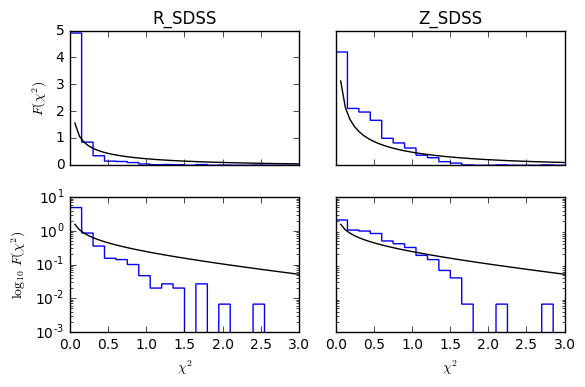

In [10]:
# Plot the chi2 distributions for each band (1 degree of freedom)
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True)
x = np.linspace(0, 3, 50)
for i, ib in enumerate(bandsCV):    
    axs[0, i].plot(x, scipy.stats.chi2.pdf(x, 1), 'k')
    axs[0, i].hist(all_chi2s[:, i], 20, range=[0, x[-1]], histtype='step', normed=True, lw=1)
    axs[1, i].plot(x, scipy.stats.chi2.pdf(x, 1), 'k')
    axs[1, i].hist(all_chi2s[:, i], 20, range=[0, x[-1]], histtype='step', normed=True, lw=1)
    axs[1, i].set_yscale('log')
    axs[1, i].set_xlabel('$\chi^2$')
    axs[0, i].set_title(bandNames[ib])
    if i == 0:
        axs[0, i].set_ylabel('$F(\chi^2)$')
        axs[1, i].set_ylabel('$\log_{10}\ F(\chi^2)$')
    else:
        axs[0, i].set_yticks([])
        axs[1, i].set_yticks([])
fig.tight_layout()